In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns
from collections import defaultdict
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
import math
%matplotlib inline

df_cal = pd.read_csv('calendar.csv')
df_lis = pd.read_csv('listings.csv')
df_rev = pd.read_csv('reviews.csv')

First I would like to know about the dimentions of each dataset.

In [2]:
print(df_cal.shape)
print(df_lis.shape)
print(df_rev.shape)

(1393570, 4)
(3818, 92)
(84849, 6)


The listings show each house's informations so I would like to know more about this dataset, starting with the column names and data types of each house.

In [3]:
df_lis.dtypes.value_counts()

object     62
float64    17
int64      13
dtype: int64

In [34]:
df_lis.dtypes[df_lis.dtypes=='float64']

host_listings_count            float64
host_total_listings_count      float64
latitude                       float64
longitude                      float64
bathrooms                      float64
bedrooms                       float64
beds                           float64
square_feet                    float64
review_scores_rating           float64
review_scores_accuracy         float64
review_scores_cleanliness      float64
review_scores_checkin          float64
review_scores_communication    float64
review_scores_location         float64
review_scores_value            float64
license                        float64
reviews_per_month              float64
dtype: object

In [35]:
df_lis.dtypes[df_lis.dtypes=='int64']

id                                int64
scrape_id                         int64
host_id                           int64
accommodates                      int64
guests_included                   int64
minimum_nights                    int64
maximum_nights                    int64
availability_30                   int64
availability_60                   int64
availability_90                   int64
availability_365                  int64
number_of_reviews                 int64
calculated_host_listings_count    int64
dtype: object

In [36]:
pd.set_option('display.max_rows', 92)
df_lis.dtypes[df_lis.dtypes=='object']

listing_url                         object
last_scraped                        object
name                                object
summary                             object
space                               object
description                         object
experiences_offered                 object
neighborhood_overview               object
notes                               object
transit                             object
thumbnail_url                       object
medium_url                          object
picture_url                         object
xl_picture_url                      object
host_url                            object
host_name                           object
host_since                          object
host_location                       object
host_about                          object
host_response_time                  object
host_response_rate                  object
host_acceptance_rate                object
host_is_superhost                   object
host_thumbn

There are many columns that are considered as object, yet some of they should be treated as integer or float (especially those price columns.) This is a type change problem that I will handle later. For now I would like to know about the number missing values and number of unique inputs in each column.

In [37]:
df_lis.isnull().sum().sort_values(ascending=False)

license                             3818
square_feet                         3721
monthly_price                       2301
security_deposit                    1952
weekly_price                        1809
notes                               1606
neighborhood_overview               1032
cleaning_fee                        1030
transit                              934
host_about                           859
host_acceptance_rate                 773
review_scores_accuracy               658
review_scores_checkin                658
review_scores_value                  656
review_scores_location               655
review_scores_cleanliness            653
review_scores_communication          651
review_scores_rating                 647
reviews_per_month                    627
first_review                         627
last_review                          627
space                                569
host_response_time                   523
host_response_rate                   523
neighbourhood   

In [38]:
df_lis.nunique()[df_lis.nunique()==len(df_lis)]

id             3818
listing_url    3818
picture_url    3818
latitude       3818
longitude      3818
dtype: int64

In [39]:
df_lis.nunique()[df_lis.nunique() != len(df_lis)].sort_values(ascending=False)

name                                3792
description                         3742
medium_url                          3498
thumbnail_url                       3498
xl_picture_url                      3498
summary                             3478
amenities                           3284
space                               3119
host_id                             2751
host_url                            2751
host_picture_url                    2743
host_thumbnail_url                  2743
transit                             2574
neighborhood_overview               2506
host_about                          2011
notes                               1999
host_name                           1466
street                              1442
host_since                          1380
first_review                         984
reviews_per_month                    654
weekly_price                         395
availability_365                     363
monthly_price                        356
last_review     

#### Question-1

When I look into the dataset, I see **amenities** column which gives detailed information about features of the listing. I would like to know what are the most common amenities that are available in Seattle Airbnb dataset. So the question is: What are the most common amenities?

The code in the below cell creates the list of amenties available.

In [35]:
#I first create an empty list to fill with amenities available.
list_of_amenities = []

#I create a for loop to append all amenities values from the dataset into the list.
for i in range(len(df_lis)):
    list_of_amenities.append(df_lis['amenities'][i])

    
#In the dataset, every listing has a list of amenities, so in order to take unique amenities from the whole dataset
#I use the below code. I use the "set" function to make the amenities unique and than convert the set into a list
#to remain consistency of data type.
list_of_amenities = list((s.strip('\'\{\}') for s in list_of_amenities))
list_of_amenities_string = ",".join(list_of_amenities)
list_of_amenities = list(set(list_of_amenities_string.split(",")))

#After execution the above lines in this cell, we have an empty string in the list of amenties.
#We have to remove that one from the list.
without_empty_list_of_amenities = []
for string in list_of_amenities:
    if (string != ""):
        without_empty_list_of_amenities.append(string)
list_of_amenities = without_empty_list_of_amenities

The code in the below cell is taken from one of the Udacity lecture notes (named: HowToBreakIntoTheField.py).
This function is used to count the number of listings that contains each amenity in the amenities list.

In [36]:
def total_count(df, col1, col2, look_for):
    '''
    INPUT:
    df - the pandas dataframe you want to search
    col1 - the column name you want to look through
    col2 - the column you want to count values from
    look_for - a list of strings you want to search for in each row of df[col]

    OUTPUT:
    new_df - a dataframe of each look_for with the count of how often it shows up
    '''
    new_df = defaultdict(int)
    #loop through list of amenities
    for val in look_for:
        #loop through rows
        for idx in range(df.shape[0]):
            #if the amenity is in the row add 1
            if val in df[col1][idx]:
                new_df[val] += int(df[col2][idx])
    new_df = pd.DataFrame(pd.Series(new_df)).reset_index()
    new_df.columns = [col1, col2]
    new_df.sort_values('count', ascending=False, inplace=True)
    return new_df

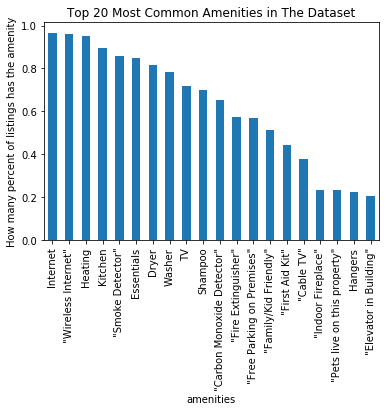

In [45]:
#I create a dataframe named study, which has lists of amenities as one column and the count of these amenities lists
#in our main (df_lis)
study = df_lis['amenities'].value_counts().reset_index()
study.rename(columns={'index': 'amenities', 'amenities': 'count'}, inplace=True)

#Here with the total_count function, I count the number of listings that contains each amenity in the amenities list.
study_df = total_count(study, 'amenities', 'count', list_of_amenities)
study_df.set_index('amenities', inplace=True)

#Here I create a bar chart to show the percentage of each amenity from the most common to the least common.
(study_df/len(df_lis))[:20].plot(kind='bar', legend=None);
plt.title('Top 20 Most Common Amenities in The Dataset');
plt.ylabel('How many percent of listings has the amenity')
plt.show()

In the above chart you can see that the most common amenities in Seattle listings are:
- Internet
- Wireless Internet
- Heating
- Smoke Detector
- Essentials



Whereas the least common amenities in Seattle listings are:
- Lock on Bedroom Door
- Doorman
- Smoking Allowed
- Other pet(s)
- Washer / Dryer

#### Question-2

When I look into the dataset, I see some important features of listigs. Some of these features have seperate columns (for example property_type or room_type) and some of these features are in **amenities** column. What I would like to know about this dataset is, "What attracts the guests most for renting a property?". I will try to answer this question below.

In order to understand the popularity of a listing I will use the **availability_30** column. Because it gives an idea about the occupation ratio (or popularity) of the property.

In [51]:
#Check if availability_30 column has an missing values. I will use this columns for occupation_ratio_30.
df_lis['availability_30'].isnull().sum()

0

In [52]:
df_lis['occupation_ratio_30'] = 1 - (df_lis['availability_30']/30)

In [49]:
df_lis['occupation_ratio_30'].head()

0    0.533333
1    0.566667
2    0.966667
3    1.000000
4    0.000000
Name: occupation_ratio_30, dtype: float64

Above, I found a percantage on occupation ratio of each listing. Now I will have to make seperate columns for each of the features that I will investige whether they attract the guests for choosing the listing to rent.

First feature I would like to investigate is **room_type**.

In [43]:
df_lis['room_type'].isnull().sum()

0

In [44]:
df_lis['room_type'].value_counts().sort_values(ascending=False)

Entire home/apt    2541
Private room       1160
Shared room         117
Name: room_type, dtype: int64

Above, I found that there is not any missing values in the room_type column and also there are three different types of rooms. How about these different rooms occupation ratios?

In [45]:
df_lis.groupby(['room_type'])['occupation_ratio_30'].mean().sort_values(ascending=False)

room_type
Entire home/apt    0.483353
Private room       0.362759
Shared room        0.279202
Name: occupation_ratio_30, dtype: float64

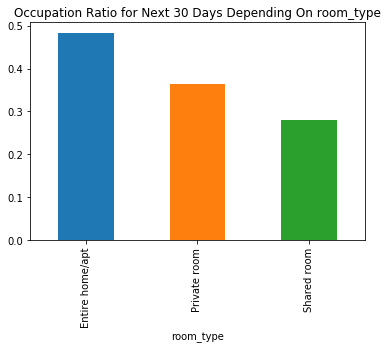

In [3]:
(df_lis.groupby(['room_type'])['occupation_ratio_30'].mean().sort_values(ascending=False)).plot(kind='bar', legend=None)
plt.title('Occupation Ratio for Next 30 Days Depending On room_type');
plt.show()

In [47]:
df_lis['property_type'].value_counts().sort_values(ascending=False)

House              1733
Apartment          1708
Townhouse           118
Condominium          91
Loft                 40
Bed & Breakfast      37
Other                22
Cabin                21
Camper/RV            13
Bungalow             13
Boat                  8
Tent                  5
Treehouse             3
Chalet                2
Dorm                  2
Yurt                  1
Name: property_type, dtype: int64

In [48]:
df_lis.groupby(['property_type'])['occupation_ratio_30'].mean().sort_values(ascending=False)

property_type
Tent               0.800000
Dorm               0.666667
Treehouse          0.666667
Chalet             0.500000
Cabin              0.469841
Apartment          0.456011
Condominium        0.454579
Loft               0.435000
House              0.432583
Townhouse          0.413559
Camper/RV          0.410256
Other              0.301515
Bed & Breakfast    0.257658
Boat               0.250000
Bungalow           0.215385
Yurt               0.066667
Name: occupation_ratio_30, dtype: float64

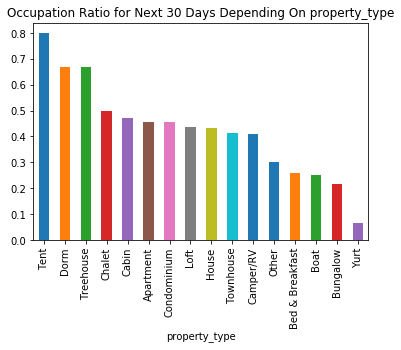

In [50]:
(df_lis.groupby(['property_type'])['occupation_ratio_30'].mean().sort_values(ascending=False)).plot(kind='bar', legend=None)
plt.title('Occupation Ratio for Next 30 Days Depending On property_type');
plt.show()

How about the **amenities** and their effect for attracting the guest? In order to answer the first question I had created the list of amenities which will be useful here to answer the second question.

In [53]:
#Check if amenities column has an missing values.
df_lis['amenities'].isnull().sum()

0

In [54]:
#Here I create new columns for each of the amenities and fill them all with zeros.
for i in range(len(list_of_amenities)):
    df_lis[list_of_amenities[i]] = 0

In [55]:
#Here I fill the new amenities columns, by first checking if the listing has that amenity.
#If the listing has that amenity I fill it with 1 and if it does not have it, I fill it with zero.
#Below code, takes about **3 minutes** to work on my machine.
for i in range(len(list_of_amenities)):
    for t in range(len(df_lis)):
        if list_of_amenities[i] in df_lis['amenities'][t]:
            df_lis.loc[t , list_of_amenities[i]] = 1
        else:
            df_lis.loc[t , list_of_amenities[i]] = 0

In [58]:
#Here I create a dataframe that will contain information about occupation ratio of listings that contain the amenity.
amenities_importance = pd.DataFrame(index=range(0,len(list_of_amenities)), columns = ["Amenity_Name", "Occupation Ratio for HAVING the Amenity", "Occupation Ratio for NOT HAVING the Amenity", "Occupation Difference"])


#In the below for loop, I write the name of the amenity, calculate the occupation ratio of listings that contain the amenitiy
#and calculate the occupation ratio of listings that do not contain the amenitiy
#and calculate the difference between occupation ratios for each amenity. 
for i in range(len(list_of_amenities)):
    amenities_importance['Amenity_Name'][i] = list_of_amenities[i]
    amenities_importance['Occupation Ratio for HAVING the Amenity'][i] = df_lis.groupby([list_of_amenities[i]])['occupation_ratio_30'].mean()[1]
    amenities_importance['Occupation Ratio for NOT HAVING the Amenity'][i] = df_lis.groupby([list_of_amenities[i]])['occupation_ratio_30'].mean()[0]
    amenities_importance['Occupation Difference'][i] = amenities_importance['Occupation Ratio for HAVING the Amenity'][i] - amenities_importance['Occupation Ratio for NOT HAVING the Amenity'][i]

amenities_importance.set_index('Amenity_Name', inplace=True)

In [60]:
#Here I list the Top 10 occupation difference to see which amenities are most prefered by guests.
amenities_importance.sort_values(by='Occupation Difference', ascending = False)[:10]

,Occupation Ratio for HAVING the Amenity,Occupation Ratio for NOT HAVING the Amenity,Occupation Difference
Amenity_Name,,,
"""Washer / Dryer""",0.616667,0.440365,0.176302
Kitchen,0.451154,0.347764,0.10339
Cat(s),0.486649,0.435322,0.0513271
"""Pets Allowed""",0.47959,0.434937,0.0446532
"""Other pet(s)""",0.48366,0.439873,0.0437876
Dryer,0.448523,0.404782,0.0437406
Washer,0.449543,0.407546,0.0419968
"""Smoke Detector""",0.445992,0.406642,0.0393502
"""Pets live on this property""",0.464477,0.433231,0.031246


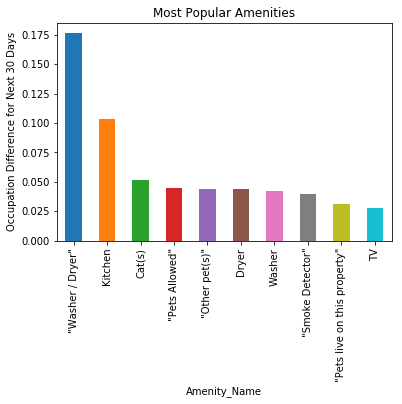

In [61]:
#Here I draw a bar chart to visualize which amenities are most prefered by guests.
amenities_importance['Occupation Difference'].sort_values(ascending = False)[:10].plot(kind='bar', legend=None)
plt.title('Most Popular Amenities');
plt.ylabel('Occupation Difference for Next 30 Days')
plt.show()

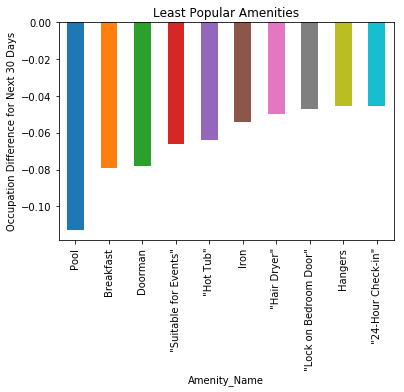

In [62]:
#Here I draw a bar chart to visualize which amenities are least prefered by guests.
amenities_importance['Occupation Difference'].sort_values(ascending = True)[:10].plot(kind='bar', legend=None)
plt.title('Least Popular Amenities');
plt.ylabel('Occupation Difference for Next 30 Days')
plt.show()

So for the answer of Question-2 ("What attracts the guests most for renting a property?") we can say that having a Washer/Dryer increases the occupation rate for next 30 days more than 15%. Also having a kitchen and allowing pets are good ideas for increasing the popularity for a listing.

Also when comparing different room_types, an "Entire home/apt" is more than 10% more popular than a private room or a shared room.
It looks like having a pool or serving breakfast does not help a listing to be preferred, probably because of the increased price with these amenities

#### Question-3

There are so many features in the dataset, that has effect on the price of the listing. In the third question I would like to train a model to estimate the price of a listing. So the question I would like to answer is: How can we estimate the price of a listing, what are the most influencial features of the dataset to estimate the price of a listing.

First I would like to know about the number of missing values in the features that are related to price.

In [63]:
print(df_lis['price'].isnull().sum())
print(df_lis['weekly_price'].isnull().sum())
print(df_lis['monthly_price'].isnull().sum())
print(df_lis['security_deposit'].isnull().sum())
print(df_lis['cleaning_fee'].isnull().sum())

0
1809
2301
1952
1030


There are five different prices in the dataset, which are listed below.
- price
- weekly_price
- monthly_price
- security_deposit
- cleaning_fee

In the code cell above, I find the number of null values in each column. As can be seen, some of the listings do not have weekly or monthly price. So it is a better idea to model the "price" because of larger sample size.
I will not take into account the security deposit and cleaning fee.

In [64]:
#Below, I made a list of important features in my opinion for estimating the price of a listing and created
#a sub-dataframe of listings dataframe.

#In order to answer the first question, I made columns for amenities categorical value, I will use all amenities columns
#I created there.

features_of_interest = ['bathrooms', 'bedrooms', 'beds', 'latitude', 'longitude', 'square_feet', 'reviews_per_month',
        'occupation_ratio_30', 'accommodates', 'guests_included', '"24-Hour Check-in"', '"Suitable for Events"',
       '"Pets live on this property"', 'Dog(s)', '"Smoking Allowed"',
       '"Other pet(s)"', 'Essentials', '"Wireless Internet"',
       '"Buzzer/Wireless Intercom"', 'TV', 'Gym', 'Washer', 'Doorman', 'Dryer',
       '"Hot Tub"', '"Air Conditioning"', '"Pets Allowed"', 'Pool',
       '"Hair Dryer"', '"Fire Extinguisher"', 'Breakfast', '"Washer / Dryer"',
       '"Laptop Friendly Workspace"', '"Free Parking on Premises"',
       '"Lock on Bedroom Door"', 'Cat(s)', 'Hangers', '"Family/Kid Friendly"',
       '"Carbon Monoxide Detector"', '"Safety Card"', 'Kitchen',
       '"Elevator in Building"', 'Internet', 'Shampoo', '"Smoke Detector"',
       '"Wheelchair Accessible"', 'Iron', '"First Aid Kit"',
       '"Indoor Fireplace"', '"Cable TV"', 'Heating', 'host_is_superhost', 'neighbourhood_group_cleansed',
        'property_type','room_type','bed_type','price','security_deposit',
        'cleaning_fee', 'extra_people', 'instant_bookable', 'cancellation_policy']

df_lis_ml = df_lis[features_of_interest]

In [65]:
#Now lets check the missing values in each columns and find a way to fill them.

df_lis_ml.isnull().sum()[df_lis_ml.isnull().sum()>0]

bathrooms              16
bedrooms                6
beds                    1
square_feet          3721
reviews_per_month     627
host_is_superhost       2
property_type           1
security_deposit     1952
cleaning_fee         1030
dtype: int64

There are only 9 columns that have missing values. Here is the strategy that I have for filling each of the columns:
- Almost all of **square_feet** are missing. So I decided to drop that columns since I have columns like beds, bedrooms and bathrooms columns that can replace the square_feet.
- bathrooms, bedrooms and beds have very few missing values. reviews_per_month also has some missing values. Since all these columns are float, I will fill the missing values with the mean of that column.
- host_is_superhost and property_type are categorical columns so for filling the missing values (which are very few) I will use the mode.
- security_deposit and cleaning_fee have object data type. I will change this later but for now I want to fill the missing values. The missing values here most probably mean they are equal to zero, so I will fill them with zero.

In [66]:
#Here I drop the 'square_feet' column since there are many missing values and
#columns like beds, bedrooms and bathrooms columns that can replace the square_feet

df_lis_ml = df_lis_ml.drop(columns='square_feet')

In [67]:
#Below, I replace the missing values of 4 features (bathrooms, bedrooms, beds and reviews_per_month) with
#mean values of each feature in the dataset.

df_lis_ml['bathrooms'].fillna(df_lis_ml['bathrooms'].mean(), inplace=True)
df_lis_ml['bedrooms'].fillna(df_lis_ml['bedrooms'].mean(), inplace=True)
df_lis_ml['beds'].fillna(df_lis_ml['beds'].mean(), inplace=True)
df_lis_ml['reviews_per_month'].fillna(df_lis_ml['reviews_per_month'].mean(), inplace=True)

In [68]:
#Below, I replace the missing values of 2 features (host_is_superhost and property_type) with
#mode values (most common) of each feature in the dataset.

df_lis_ml['host_is_superhost'].fillna(df_lis_ml['host_is_superhost'].mode()[0], inplace=True)
df_lis_ml['property_type'].fillna(df_lis_ml['property_type'].mode()[0], inplace=True)

In [69]:
#Below, I replace the missing values of 2 features (security_deposit and cleaning_fee) with zeros.
#The missing values in these features most probably mean they are equal to zero

df_lis_ml['security_deposit'].fillna(0, inplace=True)
df_lis_ml['cleaning_fee'].fillna(0, inplace=True)

Now I will check the datatypes, make necessary changes for the datatypes. Also I will have to make new columns for categorical columns.

In [70]:
df_lis_ml.dtypes

bathrooms                       float64
bedrooms                        float64
beds                            float64
latitude                        float64
longitude                       float64
reviews_per_month               float64
occupation_ratio_30             float64
accommodates                      int64
guests_included                   int64
"24-Hour Check-in"                int64
"Suitable for Events"             int64
"Pets live on this property"      int64
Dog(s)                            int64
"Smoking Allowed"                 int64
"Other pet(s)"                    int64
Essentials                        int64
"Wireless Internet"               int64
"Buzzer/Wireless Intercom"        int64
TV                                int64
Gym                               int64
Washer                            int64
Doorman                           int64
Dryer                             int64
"Hot Tub"                         int64
"Air Conditioning"                int64


The following columns have to change from object to float:
- price
- security_deposit
- cleaning_fee

In [71]:
#In the columns that have information about price, the $ signs and (comma) signs has to be removed. 

df_lis_ml['price'] = df_lis_ml['price'].str.replace('$', '')
df_lis_ml['security_deposit'] = df_lis_ml['security_deposit'].str.replace('$', '')
df_lis_ml['cleaning_fee'] = df_lis_ml['cleaning_fee'].str.replace('$', '')
df_lis_ml['extra_people'] = df_lis_ml['extra_people'].str.replace('$', '')

df_lis_ml['price'] = df_lis_ml['price'].str.replace(',', '')
df_lis_ml['security_deposit'] = df_lis_ml['security_deposit'].str.replace(',', '')
df_lis_ml['cleaning_fee'] = df_lis_ml['cleaning_fee'].str.replace(',', '')
df_lis_ml['extra_people'] = df_lis_ml['extra_people'].str.replace(',', '')

#Removing $ and , signs made 0 (zero) values NaN again. So I have to fillna with 0 again. 
df_lis_ml['security_deposit'].fillna(0, inplace=True)
df_lis_ml['cleaning_fee'].fillna(0, inplace=True)

In [72]:
#Changing data type from string to float.
df_lis_ml['price'] = df_lis_ml['price'].astype(float)
df_lis_ml['security_deposit'] = df_lis_ml['security_deposit'].astype(float)
df_lis_ml['cleaning_fee'] = df_lis_ml['cleaning_fee'].astype(float)
df_lis_ml['extra_people'] = df_lis_ml['extra_people'].astype(float)

In [73]:
#creating a new dataframe which is a subset of categorical columns of out df_lis_ml dataframe
cat_cols = df_lis_ml.select_dtypes(include=['object'])

In [74]:
cat_cols.head()

,host_is_superhost,neighbourhood_group_cleansed,property_type,room_type,bed_type,instant_bookable,cancellation_policy
0,f,Queen Anne,Apartment,Entire home/apt,Real Bed,f,moderate
1,t,Queen Anne,Apartment,Entire home/apt,Real Bed,f,strict
2,f,Queen Anne,House,Entire home/apt,Real Bed,f,strict
3,f,Queen Anne,Apartment,Entire home/apt,Real Bed,f,flexible
4,f,Queen Anne,House,Entire home/apt,Real Bed,f,strict


In [75]:
# Making new columns from categorical variables in order to use these features in ML regression algoritm.
for col in cat_cols:
    try:
        df_lis_ml = pd.concat([df_lis_ml.drop(col, axis=1), pd.get_dummies(df_lis_ml[col], prefix=col, prefix_sep='_', drop_first=True)], axis=1)
    except:
        continue

Since I made the data ready, I will try Linear Regression to estimate price depending on features I selected.

In [76]:
#Creating the X (feautures) and y (the variable to be modelled) dataframes
y = df_lis_ml['price']
X = df_lis_ml.drop(columns='price')

In [77]:
#Splitting the new dataframes into train and test dataframes
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

In [78]:
#Applying the linear regression, fitting the model, making predictions with the test set and scoring the success of the model
lm_model = LinearRegression(normalize=True)
lm_model.fit(X_train, y_train)
y_test_preds = lm_model.predict(X_test)
test_score = r2_score(y_test, y_test_preds)
print(test_score)

0.6193258748837267


The r-squared value of my model is 0.619 which is not too high.

I want to investigate about the coefficients of my model. Below function is taken from one of the Udacity jupyter notebook examples. I used this code to see coefficients of my model.

In [79]:
#Below function is taken from one of the Udacity jupyter notebook examples. I used this code to see coefficients of my model. 
def coef_weights(coefficients, X_train):
    '''
    INPUT:
    coefficients - the coefficients of the linear model 
    X_train - the training data, so the column names can be used
    OUTPUT:
    coefs_df - a dataframe holding the coefficient, estimate, and abs(estimate)
    
    Provides a dataframe that can be used to understand the most influential coefficients
    in a linear model by providing the coefficient estimates along with the name of the 
    variable attached to the coefficient.
    '''
    coefs_df = pd.DataFrame()
    coefs_df['est_int'] = X_train.columns
    coefs_df['coefs'] = lm_model.coef_
    coefs_df['abs_coefs'] = np.abs(lm_model.coef_)
    coefs_df = coefs_df.sort_values('abs_coefs', ascending=False)
    return coefs_df

#Use the function
coef_df = coef_weights(lm_model.coef_, X_train)

Below is the list features that are the most influential coefficients. 

In [80]:
coef_df.head(15)

,est_int,coefs,abs_coefs
71,property_type_Boat,173.995502,173.995502
3,latitude,-76.983483,76.983483
86,room_type_Shared room,-70.314136,70.314136
74,property_type_Camper/RV,65.863014,65.863014
41,Internet,-39.714560,39.714560
77,property_type_Dorm,-36.312534,36.312534
85,room_type_Private room,-36.260990,36.260990
16,"""Wireless Internet""",35.356470,35.356470
79,property_type_Loft,34.216056,34.216056
83,property_type_Treehouse,30.796264,30.796264


In order to increase r-squared value I will use SelectKBest.
Below I write a function that tests different "k" numbers and compare r-squared for each k value.

In [82]:
def find_optimal_number_of_selectors(X, y, k_samples, plot=True):
    '''
    INPUT:
    X dataframe that contains the features.
    y dataframe that contains the variable to be predicted.
    k_samples is a list of k values that will be tested.
    
    OUTPUT:
    A dictionary that contains values of tested k-values as keys and r-squared values for each key.
    The k-value that has the highest r-squared.

    '''   
    result_r_squareds = []
    results = {}
    for kes in k_samples:
        selector = SelectKBest(score_func=f_regression, k=kes)
        selector.fit_transform(X, y)
        selected_cols = selector.get_support(indices=True)
        features_new_X = X.iloc[:,selected_cols]
        
        X_train, X_test, y_train, y_test = train_test_split(features_new_X, y, test_size = 0.2, random_state=42)
        lm_model = LinearRegression(normalize=True)
        lm_model.fit(X_train, y_train)
        y_test_preds = lm_model.predict(X_test)
        result_r_squareds.append(r2_score(y_test, y_test_preds))
        results[str(kes)] = r2_score(y_test, y_test_preds)
    
    if plot:
        plt.plot(k_samples, result_r_squareds, label="r-squared", alpha=0.5)
        plt.xlabel("Different k_values")
        plt.ylabel("R_Squared_Values")
        plt.legend(loc=1)
        plt.show()
    
    best_k = max(results, key=results.get)
    
    return results, best_k

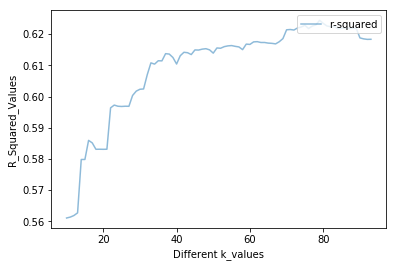

{'10': 0.5610719934185295, '11': 0.5613631161773542, '12': 0.5618706404225703, '13': 0.5627192753466563, '14': 0.5798179780206143, '15': 0.5798260185879054, '16': 0.5859423320366866, '17': 0.5851382220911276, '18': 0.5830889041071928, '19': 0.583108720671921, '20': 0.5830826716960481, '21': 0.5831107940544074, '22': 0.5963593970815535, '23': 0.597254245569952, '24': 0.5968826231621435, '25': 0.5968069326103846, '26': 0.5968841784629721, '27': 0.5968631459356524, '28': 0.6003294350498094, '29': 0.6017226468717223, '30': 0.602318975630783, '31': 0.6024150140594315, '32': 0.6069779362311487, '33': 0.6107747907289507, '34': 0.61037428960775, '35': 0.6114487579913673, '36': 0.6114166183813403, '37': 0.6137229730801959, '38': 0.613592907659579, '39': 0.6124991835786586, '40': 0.6104062820955698, '41': 0.6130624963208636, '42': 0.6141644667037677, '43': 0.6140255891359947, '44': 0.6134345497904742, '45': 0.6149222913789415, '46': 0.6148767047130205, '47': 0.6151736281808575, '48': 0.615316386

In [84]:
#I test a range of k values from 10 to 94 (which is the number of all features)
#and find the number of features that generate the highest r-squared value.
k_samples = range(10, len(X.columns))
emre_results, emre_best_k = find_optimal_number_of_selectors(X, y, k_samples)
print(emre_results)
print(emre_best_k)
print(emre_results[emre_best_k])

The highest r-squared value is achieved with 79 features and the r-squared value is 0,6244

#### Question-4

In the dataset we have latitude and longitude that gives information about the location of the listing. I would like to investigate effect of listings' proximity to Seattle Downtown. Does it increase the price or decrease the price to be close to downtown. And how much does it effect the price? This is my final question to answer.

Below I write a function that calculate the distance from downtown. According to Google Maps the coordinates of Seattle downtown are [47.605151, -122.334379] This is the coordinate that I will calculate the distance of every listing.

In [86]:
def distance_from_downtown(lat, lon, downtown=[47.605151, -122.334379]):
    '''
    INPUT:
    lat is the latitude of the point that I will calculate distance.
    lon is the longitude of the point that I will calculate distance.
    downtown is the coordinate of Seattle Downtown according to Google Maps. Downtown variable can be different, if the
    distance is expected to be calculated from a different point.
    
    OUTPUT:
    Distance between the point and the downtown.
    '''   
    R = 6373.0
    lat1 = math.radians(downtown[0])
    lon1 = math.radians(downtown[1])
    lat2 = math.radians(lat)
    lon2 = math.radians(lon)
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = math.sin(dlat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    distance = R * c
    return distance

In [87]:
#Below I make a for look to calculate the distance of each listing from downtown.
#I create a new variable called 'distance_from_downtown' which has the information of distance of listing from downtown. 
for i in range(len(df_lis_ml)):
    df_lis_ml.loc[ i , 'distance_from_downtown'] = distance_from_downtown(df_lis_ml.loc[ i ,'latitude'] , df_lis_ml.loc[ i ,'longitude'])

In [ ]:
#Since we added a distance variable, we do not need 'latitude', 'longitude' columns.
df_lis_ml.drop(columns=['latitude', 'longitude'], inplace=True)

Lets make another regression model with distance from downtown variable.

In [94]:
#Creating the X (feautures) and y (the variable to be modelled) dataframes
y = df_lis_ml['price']
X = df_lis_ml.drop(columns='price')

In [95]:
#Splitting the new dataframes into train and test dataframes
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

In [96]:
#Applying the linear regression, fitting the model, making predictions with the test set and scoring the success of the model
lm_model = LinearRegression(normalize=True)
lm_model.fit(X_train, y_train)
y_test_preds = lm_model.predict(X_test)
test_score = r2_score(y_test, y_test_preds)
print(test_score)

0.6234116665875442


In [98]:
#Previously I had written a function above to see coefficients of my regression model.
#The name of the function was "coef_weights"

#I use the function again to find the coefficients of the new model.
coef_df = coef_weights(lm_model.coef_, X_train)

In [100]:
#I print the coefficient of 'distance_from_downtown' variable
coef_df[coef_df['est_int'] == 'distance_from_downtown']

,est_int,coefs,abs_coefs
92,distance_from_downtown,-2.97923,2.97923


As can be seen above, the 'distance_from_downtown' feature has a negative effect on price. As the distance from downtown increases, the price of listing decreases. For one kilometer additional distance from downtown, the price of listing decrease around 3 USD. 